In [1]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import DataLoader, TensorDataset, random_split 

from torchmetrics import Accuracy 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
 
from tqdm import tqdm

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xtrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_train.pt')
ytrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_train.pt')

xvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_valid.pt')
yvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_valid.pt')

xtest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_test.pt')
ytest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_test.pt')

In [3]:
xtrain.shape, ytrain.shape

(torch.Size([7500, 2, 3000]), torch.Size([7500]))

In [4]:
xvalid.shape, yvalid.shape

(torch.Size([4094, 2, 3000]), torch.Size([4094]))

In [5]:
xtest.shape, ytest.shape

(torch.Size([9850, 2, 3000]), torch.Size([9850]))

In [6]:
#L
xtrain.shape[2]

3000

In [7]:
#F
xtrain.shape[1]

2

In [8]:
xtrain = xtrain.permute(0, 2, 1)
xvalid = xvalid.permute(0, 2, 1)
xtest  = xtest.permute(0, 2, 1)

ytrain = tc.LongTensor(np.array(ytrain))
yvalid = tc.LongTensor(np.array(yvalid))
ytest  = tc.LongTensor(np.array(ytest))

In [9]:
ytrain.unique()

tensor([0, 1, 2, 3, 4])

In [10]:
train_dataset = TensorDataset(xtrain, ytrain)
valid_dataset = TensorDataset(xvalid, yvalid)
test_daatset  = TensorDataset(xtest, ytest)

In [11]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = False)

In [12]:
x, y = next(iter(train_loader))

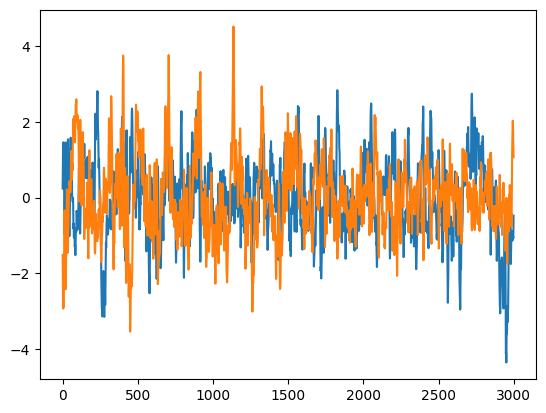

In [13]:
plt.plot(x[0])

In [14]:
device = 'cpu' if tc.cuda.is_available() else 'cpu'

In [15]:
class TransformerModel(nn.Module):
    
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, num_classes):
        super().__init__()
        
        self.encoder = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, batch_first = True, device = 'cpu').encoder
        self.fc = nn.LazyLinear(num_classes)
        
        #Expand
        self.linear = nn.LazyLinear(d_model)
        self.bn = nn.LazyBatchNorm1d()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        y = x.relu()
        y = self.encoder(y)
        y = y.flatten(1)
        y = self.fc(y)
        
        return y

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            #nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [18]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [19]:
model = TransformerModel(8, 2, 2, 0, 128, 0.1, nn.ReLU(), 5).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
model(x.to(device)).shape

torch.Size([8, 5])

In [21]:
yp = model(x.to(device))
nn.CrossEntropyLoss()(yp, y.to(device))

tensor(1.9359, grad_fn=<NllLossBackward0>)

In [22]:
mini_batch, _ = random_split(train_dataset, (50, len(train_dataset) - 50))
mini_loader  = DataLoader(mini_batch, batch_size = 4, shuffle = True)

In [23]:
optimizer = optim.SGD(model.parameters(), lr = 0.000001, momentum = 0.9)
loss_func = nn.CrossEntropyLoss()

In [24]:
N = 20
for i in range(N):
    model, _, _ = train_one_epoch(model, mini_loader, loss_func, optimizer, i)

Epoch=19: 100%|██████████| 13/13 [00:15<00:00,  1.23s/batch, Accuracy=50, loss=1.35]  


In [25]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
  print(f'LR={lr}')
  model = TransformerModel(8, 2, 2, 0, 128, 0.1, nn.ReLU(), 5).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_loader, loss_func, optimizer, epoch)
  print()

LR=0.9


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.01s/batch, Accuracy=20, loss=nan]  



LR=0.5


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.02s/batch, Accuracy=20, loss=nan]  



LR=0.2


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch, Accuracy=20, loss=nan]  



LR=0.1


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.02s/batch, Accuracy=20, loss=nan]  



LR=0.01


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.02s/batch, Accuracy=12, loss=1.62]  



LR=0.001


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch, Accuracy=100, loss=0.0544]



LR=0.0001


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch, Accuracy=60, loss=1.19]  



LR=1e-05


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.02s/batch, Accuracy=18, loss=1.65]  



LR=1e-06


Epoch=4: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch, Accuracy=12, loss=1.68]  

In [27]:
lr_n=[0.001, 0.00095, 0.0015, 0.002]
wd_n=[0, 1e-4, 1e-5, 1e-6, 1e-7]
result=[]
for lr in lr_n:
  lr_result=[]
  for wd in wd_n:
      model = TransformerModel(8, 2, 2, 0, 128, 0.1, nn.ReLU(), 5).to(device)
      optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
      N=5
      print(f'LR={lr}, weight_decay={wd}, filter={filter}')

      for i in range(N):

        model,train_loss, train_acc = train_one_epoch(model, mini_loader, loss_func, optimizer, i)

        if i==0:
          e1 = train_loss
        if i==N-1:
          e2 = train_loss

      lr_result.append(f'{e1:.4}-{e2:.4}={e1-e2:.4}')
      print()
  result.append(lr_result)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LR=0.001, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.0246]



LR=0.001, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, Accuracy=100, loss=0.029] 



LR=0.001, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, Accuracy=98, loss=0.11]   



LR=0.001, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, Accuracy=100, loss=0.0224]



LR=0.001, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, Accuracy=100, loss=0.0282]



LR=0.00095, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.051] 



LR=0.00095, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.0384]



LR=0.00095, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.0357]



LR=0.00095, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.0341]



LR=0.00095, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.0324]



LR=0.0015, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.0161]



LR=0.0015, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.012] 



LR=0.0015, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.0112]



LR=0.0015, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch, Accuracy=100, loss=0.01]   



LR=0.0015, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.0162]



LR=0.002, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.00272]



LR=0.002, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch, Accuracy=100, loss=0.00649]



LR=0.002, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.00533]



LR=0.002, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.00468]



LR=0.002, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=100, loss=0.00409]

In [28]:
pd.DataFrame(result, index = lr_n, columns = wd_n)

,0.000000e+00,1.000000e-04,1.000000e-05,1.000000e-06,1.000000e-07
0.00100,2.343-0.02458=2.318,3.654-0.02898=3.625,6.631-0.1098=6.522,2.714-0.02236=2.692,7.123-0.02821=7.095
0.00095,4.051-0.05095=4.0,3.433-0.0384=3.395,4.987-0.03568=4.951,3.348-0.0341=3.314,6.478-0.03241=6.445
0.00150,6.387-0.01613=6.371,3.657-0.01196=3.645,8.668-0.01124=8.657,5.083-0.01001=5.073,9.829-0.01622=9.813
0.00200,2.634-0.002715=2.631,6.455-0.006493=6.449,7.711-0.005334=7.705,3.913-0.004677=3.909,4.271-0.004086=4.267


In [35]:
model = TransformerModel(8, 2, 2, 0, 128, 0.1, nn.ReLU(), 5).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
optimizer = optim.SGD(model.parameters(), lr = 0.0015, momentum = 0.9, weight_decay = 1e-6)
loss_func = nn.CrossEntropyLoss()

In [37]:
loss_train_hist, acc_train_hist = [], [] 
loss_valid_hist, acc_valid_hist = [], []
best_model = [0]
best_loss = tc.inf

In [38]:
mini_valid_batch, _ = random_split(valid_dataset, (50, len(valid_dataset) - 50))
mini_valid_loader  = DataLoader(mini_valid_batch, batch_size = 4, shuffle = True)

In [39]:
N = 10
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, mini_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,mini_valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 13/13 [00:12<00:00,  1.06batch/s, Accuracy=16, loss=8.9]   


valid loss=6.519, accuracy=14.0

model saved!


Epoch=1: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch, Accuracy=86, loss=1.03]  


valid loss=11.35, accuracy=18.0



Epoch=2: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, Accuracy=96, loss=0.534]   


valid loss=10.38, accuracy=16.0



Epoch=3: 100%|██████████| 13/13 [00:22<00:00,  1.72s/batch, Accuracy=90, loss=0.743]  


valid loss=15.24, accuracy=10.0



Epoch=4: 100%|██████████| 13/13 [00:18<00:00,  1.45s/batch, Accuracy=98, loss=0.136]   


valid loss=9.399, accuracy=22.0



Epoch=5: 100%|██████████| 13/13 [00:20<00:00,  1.55s/batch, Accuracy=100, loss=1.13e-5]


valid loss=8.473, accuracy=24.0



Epoch=6: 100%|██████████| 13/13 [00:22<00:00,  1.76s/batch, Accuracy=100, loss=0.00176]


valid loss=10.05, accuracy=24.0



Epoch=7: 100%|██████████| 13/13 [00:24<00:00,  1.86s/batch, Accuracy=100, loss=1.57e-6]


valid loss=9.673, accuracy=24.0



Epoch=8: 100%|██████████| 13/13 [00:23<00:00,  1.77s/batch, Accuracy=100, loss=8.23e-7]


valid loss=10.2, accuracy=24.0



Epoch=9: 100%|██████████| 13/13 [00:25<00:00,  1.96s/batch, Accuracy=100, loss=2.26e-6]


valid loss=10.03, accuracy=24.0



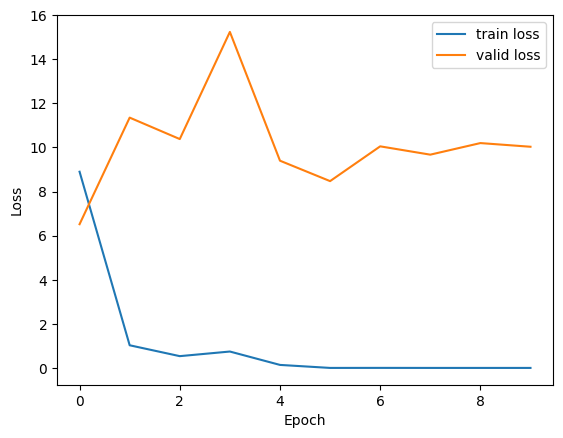

In [40]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

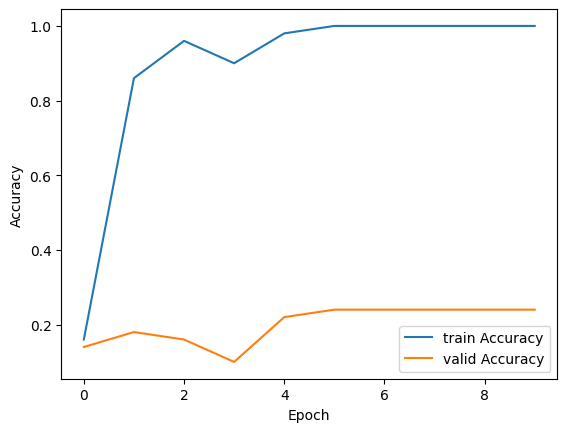

In [41]:
plt.plot(range(N), acc_train_hist, label = 'train Accuracy')
plt.plot(range(N), acc_valid_hist, label = 'valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()